# Problem Description
- Framework:          t = 0, 1, ..., 200 (T = 200)
- State:              S = {0, 1, ... , 50}
- Actions:            A = {5, 10, ... 400}
- Events:             I = {0, 1}
                    With Probabilities:
                        P(1, a) = (1 - a/400) * (1 + t) / T
- Rewards:            r(i, a, s) = a * min(s, i)
- New State:          s<sub>t</sub> -> s<sub>t+1</sub> = max(0, s-i)
- Initial State:      s<sub>0</sub> = 50
- Final State:        r<sub>t</sub> = s * f with f = 10

In [8]:
from scipy.stats import bernoulli
import matplotlib.pyplot as plt

In [9]:
time_steps: range = range(0, 201, 1)
states: range = range(0, 51, 1)
actions: range = range(5, 400, 5)
initial_state: int = 50
events: list = [1, 0]

In [20]:
def reward_function(event: int, action: int, state: int) -> int:
    """
    Reward function with respect to the
    :param event: The event in space [0, 1]
    :param action: the action (here the ticket price) in space [5, 10, ..., 400)
    :param state: the current state
    :return: ticket price * min(event, state)
    """
    return action * min(event, state)

def new_state(i, s) -> int:
    """
    Am implementation of the state transitions depending on the given event i
    :param i: the event in space [0, 1]
    :param s: the current state
    :return: max(0, s-i)
    """
    return max(0, s-i)

def probabilities(action: int, time: int) -> tuple:
    """
    :param action: the chosen action (Ticket Price)
    :param time: timestamp
    :return: probability for selling ticked for price a and for not selling ticket
    """
    p_1 = (1 - (action / 400)) * ((1 + time) / 200)  # T
    p_0 = 1 - p_1
    return p_1, p_0

def simulate_event(probability: float) -> int:
    """
    In this exercise the events can be seen as a bernoulli experiment where either one ticket is sold or none ticket is sold.
    So to simulate the happening event, a bernoulli experiment is run with the given probability p.
    :param probability: defines the probability p of the bernoulli experiment
    :return: 1 or 0 for ticket sold or not sold
    """
    return bernoulli.rvs(probability, size=1)[0]

def bellman_value_function(actions: range, state: int, time: int, expected_future_rewards: tuple,  f=10):
    """
    defines the value function according to the Bellman equation
    :param actions: the set of possible actions A(state, time)
    :param state: the current state
    :param time: the current timestep
    :param expected_future_rewards: a tuple containing the future rewards for both events ticket sold or not sold which is either same state next timestep or state - 1 next timestep
    :param f: the salvage value for t=200
    :return: bellman equation V(s, t)
    """
    max_value: float = 0
    best_action: int  = 0
    for action in actions:
        p_1, p_0 = probabilities(action=action, time=time)
        reward_1: int =  reward_function(event=1, action=action, state=state)
        reward_0: int =  reward_function(event=0, action=action, state=state)
        if time == 200:
            return f, action
        else:
            value = p_1 * (reward_1 + expected_future_rewards[0]) + p_0 * (reward_0 + expected_future_rewards[1])
            if value > max_value:
                max_value = value
                best_action = action

    return max_value, best_action

In [26]:
# Initialize the tables for the value function and the best actions (to avoid index errors they are one longer than the timestamps)
value_functions: list = [[0 for t in range(len(time_steps) + 1)] for s in states]
best_actions: list = [[0 for t in range(len(time_steps) + 1)] for a in states]

# going backwards in time
for time in time_steps.__reversed__():
    for state in states: # 0 - 50
        # Get the expected future rewards from t+1 - T for each event
        expected_future_rewards_1: float = value_functions[state - 1][time + 1] if state >= 1 else value_functions[state][time + 1]
        expected_future_rewards_0: float = value_functions[state][time + 1]

        # use Bellman Equation to obtain the best action and value of the value function
        value, action = bellman_value_function(actions=actions, time=time, state=state, expected_future_rewards=(expected_future_rewards_1, expected_future_rewards_0))

        # Store results as a table format. By inserting always in the beginning of the table at the end the table can be read from left to right
        # top left corner [0, 0] of the table denotes Time 0 State 0 while bottom right corner [200, 50] denotes Time 200 State 50
        # The columns of the table represent the time while the rows represent the states
        value_functions[state][time] = value
        best_actions[state][time] = action

## Plot the value functions over time only from [0, 20] to [0, 50]

In [25]:
best_actions[48][200]

5

Text(0, 0.5, 'Expected Rewards')

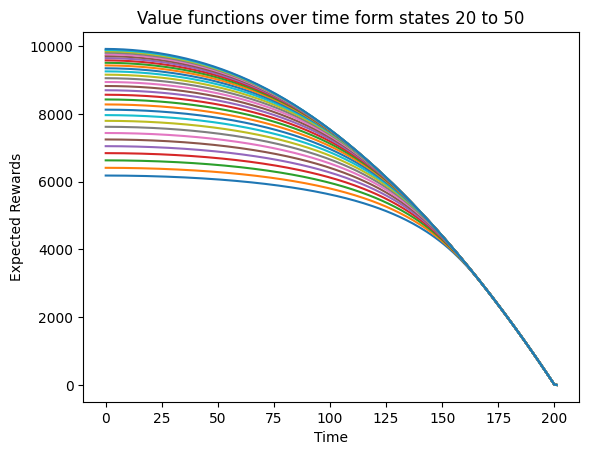

In [13]:
for i in range(20, 51, 1):
    plt.plot(value_functions[i])

plt.title("Value functions over time form states 20 to 50")
plt.xlabel("Time")
plt.ylabel("Expected Rewards")

In [15]:
# show the expected value for Time 0 and State 50
print(f"Expected value for state 50 time 0:     {value_functions[50][0]}")
print(f"Best Action for state 50 time 0:        {best_actions[50][0]}")

Expected value for state 50 time 0:     9915.641327808167
Best Action for state 50 time 0:        215


## Simulate 1000 Runs using the optimal policy obtained in task 2

In [115]:
final_rewards: list = []
for i in range(1000):
    current_state: int = initial_state
    reward: int = 0
    for time in time_steps:
        best_action: int = best_actions[current_state][time]
        p_1, _ = probabilities(action=best_action, time=time)
        event: int = simulate_event(p_1)
        reward += reward_function(event=event, state=current_state, action=best_action)
        current_state = new_state(i=event, s=current_state)

    final_rewards.append(reward)

## Inspect the results

Text(0, 0.5, 'Total Rewards')

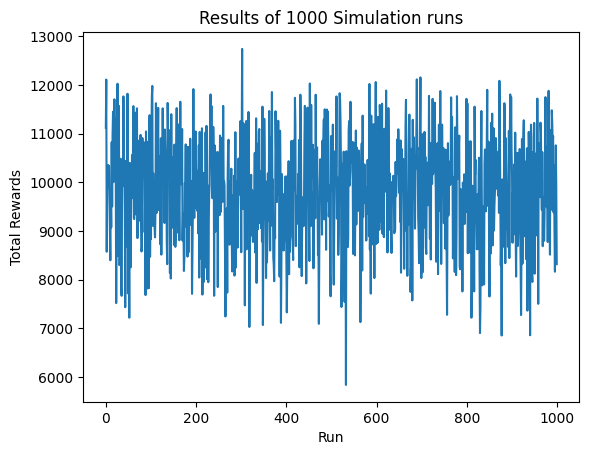

In [116]:
plt.plot(final_rewards)
plt.title("Results of 1000 Simulation runs")
plt.xlabel("Run")
plt.ylabel("Total Rewards")

Text(0, 0.5, 'Occurrences')

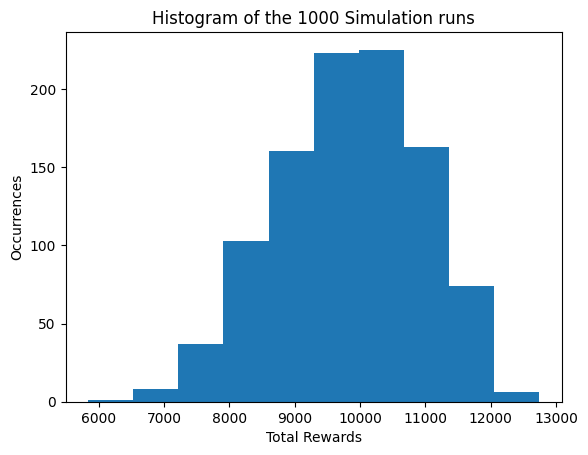

In [117]:
plt.hist(final_rewards, density=False)
plt.title("Histogram of the 1000 Simulation runs")
plt.xlabel("Total Rewards")
plt.ylabel("Occurrences")

Text(0, 0.5, 'Probability')

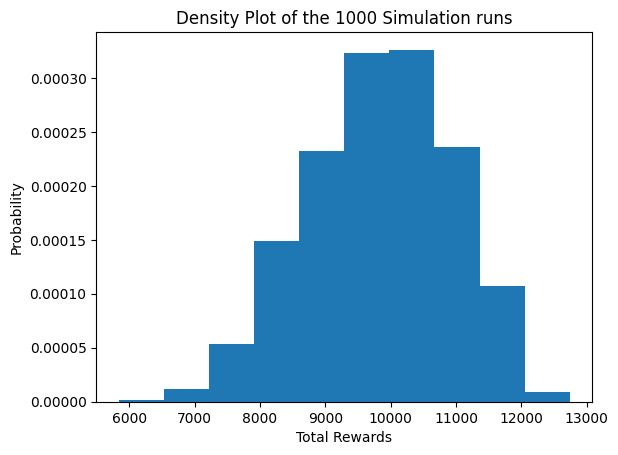

In [118]:
plt.hist(final_rewards, density=True)
plt.title("Density Plot of the 1000 Simulation runs")
plt.xlabel("Total Rewards")
plt.ylabel("Probability")